In [1]:
from matplotlib import pyplot as plt
import matplotlib
% matplotlib inline

import numpy as np
import json
import time
import os

experiment_dir = '/home/charlie/61011/experiments/1510174775-9449394'
figure_outdir = os.path.join(experiment_dir, 'figures')
if not os.path.isdir(figure_outdir):
    os.makedirs(figure_outdir)
    
plots_timestamp = experiment_timestamp = str(time.time()).replace('.', '-')

In [2]:
def load_json(filename):
    with open(filename) as fd:
        return dict(json.load(fd))

In [3]:
results_json_filenames = [
    os.path.join(experiment_dir, filename)
    for filename in os.listdir(experiment_dir)
    if filename.startswith('results_')
]

model_dirs = [
    os.path.join(experiment_dir, filename)
    for filename in os.listdir(experiment_dir)
    if filename.startswith('model_')
]
num_models = len(model_dirs)

In [4]:
trimmed_results_fns = sorted(results_json_filenames)

results_jsons = [
    load_json(filename)
    for filename in trimmed_results_fns
]

In [5]:
num_to_process = 64
measurements_dict = {}
for index in range(1, num_to_process + 1):
    index_str = str(index)
    for results_json in results_jsons:
        measurements = list(results_json[index_str]['raw'])
        if index_str in measurements_dict:
            measurements_dict[index_str]['raw'] += measurements
        else:
            measurements_dict[index_str] = {}
            measurements_dict[index_str]['raw'] = measurements

for index in range(1, num_to_process + 1):
    index_str = str(index)
    measurements_for_index = measurements_dict[index_str]['raw']
    num_measurements = len(measurements_for_index)
    measurements_dict[index_str]['mean'] = np.mean(measurements_for_index)
    measurements_dict[index_str]['std_err'] = np.std(measurements_for_index) / np.sqrt(num_measurements)
    if index == 1:
        print(len(measurements_for_index))

90


In [6]:
num_models = []
means = []
upper_bar = []
lower_bar = []
for index in range(1, num_to_process + 1):
    index_str = str(index)
    
    num_models.append(index)

    mean = measurements_dict[index_str]['mean']
    std_err = measurements_dict[index_str]['std_err']
    means.append(mean)
    upper_bar.append(mean + (1.96 * std_err))
    lower_bar.append(mean - (1.96 * std_err))
num_models = np.array(num_models)
means = np.array(means)
upper_bar = np.array(upper_bar)
lower_bar = np.array(lower_bar)

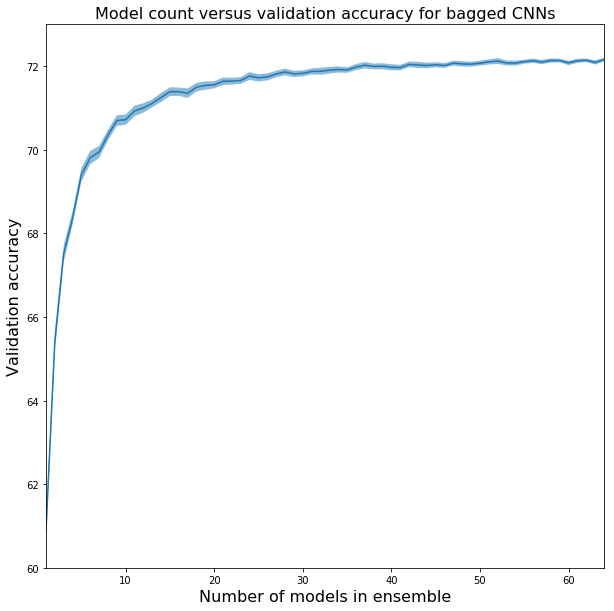

In [7]:
plt.figure(figsize=(10, 10))
plt.plot(num_models, means)
plt.fill_between(num_models, lower_bar, upper_bar, alpha=0.5)
plt.xlim([1, num_to_process])
plt.ylim([np.floor(np.min(means)), np.ceil(np.max(means))])


#old_fontsize = matplotlib.rcParams['font.size']
#matplotlib.rcParams.update({'font.size': 16})
plt.xlabel('Number of models in ensemble', fontsize=16)
plt.ylabel('Validation accuracy', fontsize=16)
plt.title('Model count versus validation accuracy for bagged CNNs', fontsize=16)
#matplotlib.rcParams.update({'font.size': old_fontsize})

plot_filename = os.path.join(figure_outdir, 'bagging_accuracy_{}.png'.format(plots_timestamp))
if not os.path.isfile(plot_filename):
    plt.savefig(plot_filename)
else:
    print('{} exists!'.format(plot_filename))

In [50]:
records = {
    'training_losses': {},
    'validation_losses': {},
    'validation_accuracies': {}
}

for model_dir in model_dirs:
    this_data = load_json(os.path.join(model_dir, 'train_stats.json'))
    this_training_loss = this_data['training_losses']
    this_validation_loss = this_data['validation_losses']
    this_validation_acc = this_data['validation_accuracies']

    enumerator = enumerate(zip(this_training_loss, this_validation_loss, this_validation_acc), 1)
    for epoch, (train_loss, val_loss, val_acc) in enumerator:
        if epoch in records['training_losses'].keys():
            records['training_losses'][epoch].append(train_loss)
            records['validation_losses'][epoch].append(val_loss)
            records['validation_accuracies'][epoch].append(val_acc)
        else:
            records['training_losses'][epoch] = [train_loss]
            records['validation_losses'][epoch] = [val_loss]
            records['validation_accuracies'][epoch] = [val_acc]

In [64]:
train_loss_vals = []
val_loss_vals = []
val_acc_vals = []
for key, val in records['training_losses'].items():
    train_loss_vals.append((key, np.mean(val), np.std(val) / np.sqrt(len(val))))
for key, val in records['validation_losses'].items():
    val_loss_vals.append((key, np.mean(val), np.std(val) / np.sqrt(len(val))))
for key, val in records['validation_accuracies'].items():
    val_acc_vals.append((key, np.mean(val), np.std(val) / np.sqrt(len(val))))
train_loss_vals = sorted(train_loss_vals)

In [66]:
epochs, means, standard_errors = zip(*train_loss_vals)